## Summary of the notebook

**train configuration**: <br> 
eager execution = enabled 

**process**:
1. Define the model and fit the model using the train, validation and test data
2. Save the trained model at specified path 
3. Use the trained model variable and pass it to the StochasticRegressor class
4. From the object returned in 3., access the predict_output() by passing the test data and number of samples desired. This function returns the samples, pred mean and pred std 
5. Plot the prediction mean and +-1 std dev against the ground truth to visualize the performance of the model 

**critical points and checklist**
1. the script should yield a trained model 
2. pdfs and pngs in the output plots folder 
3. check model training configuration once 

**analysis** 
1. for num_samples = 20 and a single input record (of shape (1,8)) <br>
intermediate samples shape : (20, 1, 1) <br> 
final mean and std/varshape : (1, 1)  


## Mount the drive

In [1]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting the correct path

In [2]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'dropconnect'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print(path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/


## Removing previous trained models

In [3]:
list_of_files = os.listdir(os.path.join(path, 'saved_models'))
print(path)

for item in list_of_files:
    if item.endswith('.h5'):
        print(f'deleting {item}')
        os.remove(os.path.join(path, 'saved_models', item))

/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/
deleting model_epochs_300_num_samples_10.h5


## Imports

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras

import os
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

#tf.compat.v1.disable_eager_execution()
print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.2
Eager execution enabled : True


## Load data

In [5]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()

# check to ensure the functionality of load function 
#print(train_labels[20])
#print(val_labels[30])
#print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## Class definitions

### StochasticModel & StochasticRegressor

In [6]:
import numpy as np
import tensorflow as tf 
import tensorflow.keras.backend as K

Layer = tf.keras.layers.Layer
Dropout = tf.keras.layers.Dropout


class DropConnect:
    def __init__(self, prob=0.5, drop_bias=False, noise_shape=None):
        self.prob = prob
        self.drop_bias = drop_bias
        self.noise_shape = noise_shape
        self.kernel_noise_shape = None
        self.bias_noise_shape = None

    @property
    def needs_drop(self):
        return 0.0 < self.prob < 1.0

    def sample(self, tensor, dropit=True, noise_shape=None):
        if dropit:
            return K.dropout(tensor, self.prob, noise_shape)

        return tensor

    def replace_tensor(self, tensor_train, tensor_test):
        if self.uses_learning_phase:
            return K.in_train_phase(tensor_train, tensor_test)
        else:
            return tensor_train

    def get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]

        return tuple(noise_shape)

    def get_config(self):
        config = {
            "prob": self.prob,
            "drop_bias": self.drop_bias,
            "noise_shape": self.noise_shape
        }

        return config

class DropConnectDense(DropConnect, Dense):
    def __init__(self, units, prob=0.5, drop_bias=False, noise_shape=None, use_learning_phase = False, **kwargs):
        DropConnect.__init__(self, prob=prob, drop_bias=drop_bias, noise_shape=noise_shape)
        Dense.__init__(self, units, **kwargs)

        if self.needs_drop:
            self.uses_learning_phase = use_learning_phase

    def call(self, inputs, **kwargs):
        kernel_sample = self.sample(self.kernel)
        bias_sample = self.sample(self.bias, dropit=self.drop_bias)

        outputs = K.dot(inputs, kernel_sample)
        
        if self.use_bias:
            outputs += bias_sample

        # This always produces stochastic outputs
        return self.activation(outputs)

    def get_config(self):
        config_dc = DropConnect.get_config(self)
        config_base = Dense.get_config(self)

        return dict(list(config_dc.items()) + list(config_base.items()))


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
            
            
class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        # https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output

    def predict_output(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))
        
        print('intermediate samples shape ', samples.shape)

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return samples, mean_pred, std_pred 

    def save(self, path):
        # stochaticmodel class does not have basic tf function like save(), summary(), get_layer() and so on 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

## Define and train dropconnect model [check if this is the correct model]

Epoch 1/300
4/4 - 1s - loss: 0.2102 - mae: 0.3921 - val_loss: 0.2177 - val_mae: 0.3984 - lr: 0.0010 - 1s/epoch - 297ms/step
Epoch 2/300
4/4 - 0s - loss: 0.1981 - mae: 0.3764 - val_loss: 0.1860 - val_mae: 0.3654 - lr: 0.0010 - 45ms/epoch - 11ms/step
Epoch 3/300
4/4 - 0s - loss: 0.2030 - mae: 0.3818 - val_loss: 0.1145 - val_mae: 0.2670 - lr: 0.0010 - 43ms/epoch - 11ms/step
Epoch 4/300
4/4 - 0s - loss: 0.1241 - mae: 0.2753 - val_loss: 0.2082 - val_mae: 0.3839 - lr: 0.0010 - 49ms/epoch - 12ms/step
Epoch 5/300
4/4 - 0s - loss: 0.1030 - mae: 0.2383 - val_loss: 0.1129 - val_mae: 0.2582 - lr: 0.0010 - 38ms/epoch - 10ms/step
Epoch 6/300
4/4 - 0s - loss: 0.0704 - mae: 0.1899 - val_loss: 0.1894 - val_mae: 0.3540 - lr: 0.0010 - 69ms/epoch - 17ms/step
Epoch 7/300
4/4 - 0s - loss: 0.0748 - mae: 0.2045 - val_loss: 0.0436 - val_mae: 0.1608 - lr: 0.0010 - 38ms/epoch - 10ms/step
Epoch 8/300
4/4 - 0s - loss: 0.0481 - mae: 0.1595 - val_loss: 0.1883 - val_mae: 0.3519 - lr: 0.0010 - 32ms/epoch - 8ms/step
Ep

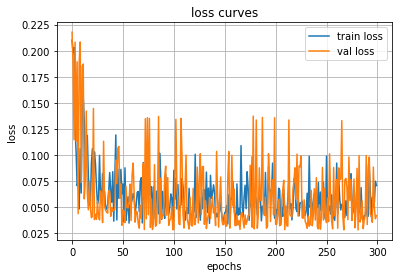

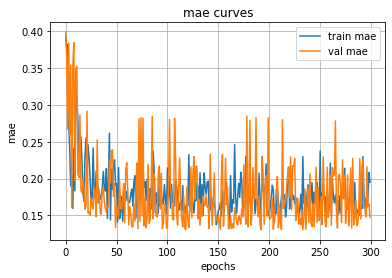

intermediate samples shape  (10, 3000, 1)
pred_samples shape  (10, 3000, 1)
pred_mean shape  (3000, 1)
pred_std shape  (3000, 1)
prediction mean :
 [[0.5018189 ]
 [0.38218042]
 [0.39985028]
 ...
 [0.16316727]
 [0.31661344]
 [0.547248  ]]
prediction mean shape  (3000, 1)
prediction std :
 [[0.1780892 ]
 [0.12324999]
 [0.1288205 ]
 ...
 [0.03702772]
 [0.11609142]
 [0.26352677]]
prediction std shape  (3000, 1)
prediction samples :
 [[[0.35656595]
  [0.2824569 ]
  [0.55591124]
  ...
  [0.20309281]
  [0.3662299 ]
  [0.65805215]]

 [[0.46122158]
  [0.25990257]
  [0.12117464]
  ...
  [0.24577448]
  [0.2845405 ]
  [0.17447725]]

 [[0.47946933]
  [0.38548642]
  [0.3990827 ]
  ...
  [0.12117464]
  [0.31297484]
  [0.4216824 ]]

 ...

 [[0.7148606 ]
  [0.2824569 ]
  [0.3990827 ]
  ...
  [0.12117464]
  [0.43309197]
  [0.7100274 ]]

 [[0.7148606 ]
  [0.29031372]
  [0.33526036]
  ...
  [0.1638563 ]
  [0.52959573]
  [0.8519547 ]]

 [[0.5493049 ]
  [0.42904162]
  [0.3197155 ]
  ...
  [0.1638563 ]
  [0.

In [7]:
# DROPCONNECT MODEL
def train_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples, prob, train_batch_size, validation_batch_size=0, test_batch_size=0):
    #obtained from hyperparameter optimization
    K.clear_session()
    model = Sequential()
    model.add(Input(shape=(8, )))

    model.add(Dense(8, activation='relu'))
    #model.add(StochasticDropout(prob))
    model.add(Dense(8, activation='relu'))
    #model.add(StochasticDropout(prob))
    model.add(Dense(8, activation='relu'))
    #model.add(StochasticDropout(prob))
   
    model.add(DropConnectDense(1, activation='relu'))

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

    def adapt_learning_rate(epoch):
        if epoch<50:
            return 1e-3
        elif epoch>50 and epoch<75:
            return 1e-4 
        else:
            return 1e-5

    lr_scheduler = keras.callbacks.LearningRateScheduler(adapt_learning_rate)
    #ckpt = keras.callbacks.ModelCheckpoint(filepath=path+uncert_name+'_model_epochs_'+str(epochs)+'_num_samples_'+str(num_samples)+'_epochs_{epoch:02d}_val_loss_{val_loss:.3f}.h5',
    #                                       monitor='val_loss',
    #                                       verbose=0,
    #                                       save_best_only=True,
    #                                       mode='auto')
                                           

    # train a model with stochasticdropout() layer
    history = model.fit(x_train, 
                        y_train, 
                        batch_size=train_batch_size,
                        validation_data=(x_val, y_val), 
                        #validation_batch_size=validation_batch_size,
                        verbose=2, 
                        epochs=epochs,
                        callbacks=[lr_scheduler])
                        #callbacks=[lr_scheduler, ckpt])
    
    #saving the model that has custom layers
    model.save(os.path.join(path, 'saved_models', 'model_epochs_'+str(epochs)+'_num_samples_'+str(num_samples)+'.h5') )
    model.summary()

    # plotting the training and validation curves
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('loss curves')
    plt.show()

    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('mae')
    plt.title('mae curves')
    plt.show()

    # call the stochasticregressor class and pass the trained model that contains the stochasticdropout layer 
    mc_model = StochasticRegressor(model)
    pred_samples, pred_mean, pred_std = mc_model.predict_output(x_test, num_samples=num_samples, batch_size=test_batch_size)
    print('pred_samples shape ', pred_samples.shape)
    print('pred_mean shape ', pred_mean.shape)
    print('pred_std shape ', pred_std.shape)

    # return the predicted_samples, predicted_mean, predicted_std and model 
    return pred_samples, pred_mean, pred_std, mc_model


epochs=300
num_samples=10
prob=0.3
train_batch_size=4096
validation_batch_size=4096
test_batch_size=4096 
# running this command creates the stochastic dropout model, trains it and generates the predicted_samples, predicted_mean and predicted_std for the test set (all 3000 examples)
prediction_samples, prediction_mean, prediction_std, stochastic_model = train_model(train_data, 
                                                                                    train_labels, 
                                                                                    val_data, 
                                                                                    val_labels, 
                                                                                    test_data, 
                                                                                    epochs=epochs, 
                                                                                    num_samples=num_samples, 
                                                                                    prob=prob,
                                                                                    train_batch_size=train_batch_size, 
                                                                                    #validation_batch_size=validation_batch_size, 
                                                                                    test_batch_size=test_batch_size)
print('prediction mean :\n', prediction_mean)
print('prediction mean shape ', prediction_mean.shape)
print('prediction std :\n', prediction_std)
print('prediction std shape ', prediction_std.shape)
print('prediction samples :\n', prediction_samples)
print('prediction samples shape ', prediction_samples.shape)

## Ground Truth vs prediction plot

In [8]:
# Analysis of the input
#num_of_samples_to_be_explained = 1
#start_index = np.random.randint(0, test_data.shape[0])
#print('start_index : ', start_index)

#test_input = test_data[start_index:start_index+num_of_samples_to_be_explained]
#print('test_input shape :', test_input.shape)

#test_input_adj = np.expand_dims(test_input, axis=-1)
#print('test_input_adj shape :', test_input_adj.shape)



# LOAD THE MODEL IN A DIFFERENT VARIABLE AND RUN THE INFERENCE (TO CHECK THE STOCHASTICITY OF THE TRAINED DROPCONNECT MODEL)
trained_model = tf.keras.models.load_model(os.path.join(path, 'saved_models', 'model_epochs_'+str(epochs)+'_num_samples_'+str(num_samples)+'.h5'),
                                           custom_objects={'DropConnectDense':DropConnectDense})
trained_model_stochastic = StochasticRegressor(trained_model)
                                     
pred_samples, pred_mean, pred_std = trained_model_stochastic.predict_output(test_data, num_samples=num_samples)
print('pred samples shape ', pred_samples.shape)
print('pred mean shape ', pred_mean.shape)
print('pred std shape ', pred_std.shape)

print('pred samples : \n ', pred_samples)
print('pred mean : \n ', pred_mean)
print('pred std : \n ', pred_std)

intermediate samples shape  (10, 3000, 1)
pred samples shape  (10, 3000, 1)
pred mean shape  (3000, 1)
pred std shape  (3000, 1)
pred samples : 
  [[[0.18207471]
  [0.59032387]
  [0.45443398]
  ...
  [0.12117464]
  [0.4094786 ]
  [0.5636097 ]]

 [[0.4003215 ]
  [0.29031372]
  [0.12117464]
  ...
  [0.12117464]
  [0.34261653]
  [0.65805215]]

 [[0.4003215 ]
  [0.34856647]
  [0.12117464]
  ...
  [0.24577448]
  [0.52959573]
  [0.51030713]]

 ...

 [[0.2258303 ]
  [0.34856647]
  [0.25589314]
  ...
  [0.24577448]
  [0.40465763]
  [0.7100274 ]]

 [[0.37481368]
  [0.29031372]
  [0.43673754]
  ...
  [0.1638563 ]
  [0.33779556]
  [0.3683798 ]]

 [[0.5493049 ]
  [0.48729435]
  [0.4211927 ]
  ...
  [0.24577448]
  [0.3662299 ]
  [0.51030713]]]
pred mean : 
  [[0.34375072]
 [0.37201232]
 [0.3563766 ]
 ...
 [0.17955092]
 [0.3715528 ]
 [0.5715195 ]]
pred std : 
  [[0.11731859]
 [0.10927048]
 [0.13429049]
 ...
 [0.04967216]
 [0.0825531 ]
 [0.1096383 ]]


indices to be plotted 
 range(0, 100)


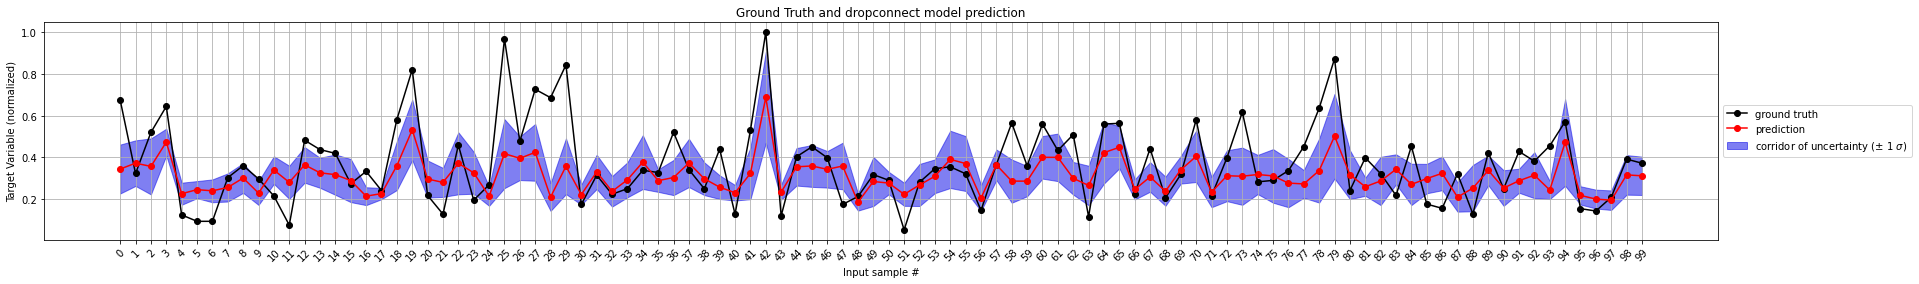

In [9]:
start_index = np.random.randint(test_data.shape[0]-150)
#random = range(start_index, start_index+100)
random = range(0, 100)
print('indices to be plotted \n', random)
test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
mean_plot = np.asarray([float(pred_mean[i]) for i in random])
std_plot = np.asarray([float(pred_std[i]) for i in random])

plot_gt_vs_pred(test_labels_plot, mean_plot, std_plot, path+'output_plots/'+uncert_name+'_gt_vs_prediction', random, uncert_name)

In [10]:
'''
##TOY CODE to test the plotting of custom horizontal bar chart 
#reference for this code below : 
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.htmlimport matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

plt.figure(figsize=(25,10))
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ['Tom', 'Dick', 'Harry', 'Slim', 'Jim']
y_pos = np.arange(1, len(people)+1)

error = np.random.rand(len(people))
performance = 3 + 10 * error

print(y_pos)
print(people)
print(performance)
print(error)


a = ax.barh(y_pos, performance, xerr=error, align='center', label='performance')

for i in range(len(a)):
    print(a[i])

ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(labels=['Tom', 'Dick', 'Harry', 'Slim', 'Jim'])

labels = ['performance', 'error']
colors = ['C0', 'k']
legend_colors = list(set(colors))
print(legend_colors)

error = plt.plot([], label='error', linestyle='-', color='k')
performance = plt.Rectangle((0,0),1,1, color='C0')

# Create a legend for the first line.
first_legend = plt.legend(handles=error)

# Add the legend manually to the current Axes. (https://matplotlib.org/2.0.2/users/legend_guide.html)

#ax.invert_yaxis()  # labels read top-to-bottom  
ax.set_xlabel('Performance') 
ax.set_title('How fast do you want to go today?')
plt.grid(alpha=0.2)
plt.legend()
plt.show()


#reference for generating a custom legend 
# https://matplotlib.org/2.0.2/users/legend_guide.html
'''

"\n##TOY CODE to test the plotting of custom horizontal bar chart \n#reference for this code below : \n# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.htmlimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Fixing random state for reproducibility\nnp.random.seed(19680801)\n\nplt.figure(figsize=(25,10))\nplt.rcdefaults()\nfig, ax = plt.subplots()\n\n# Example data\npeople = ['Tom', 'Dick', 'Harry', 'Slim', 'Jim']\ny_pos = np.arange(1, len(people)+1)\n\nerror = np.random.rand(len(people))\nperformance = 3 + 10 * error\n\nprint(y_pos)\nprint(people)\nprint(performance)\nprint(error)\n\n\na = ax.barh(y_pos, performance, xerr=error, align='center', label='performance')\n\nfor i in range(len(a)):\n    print(a[i])\n\nax.set_yticks([1, 2, 3, 4, 5])\nax.set_yticklabels(labels=['Tom', 'Dick', 'Harry', 'Slim', 'Jim'])\n\nlabels = ['performance', 'error']\ncolors = ['C0', 'k']\nlegend_colors = list(set(colors))\nprint(legend_colors)\n\nerror = plt.plot([], label='error', l